In [13]:
import torch as pt
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, classification_report
from joblib import dump

# Pre-Procesing Data

UDP CSV from https://www.kaggle.com/datasets/jacobvs/ddos-attack-network-logs/data

In this Cell we convert our csv records into a pandas dataframe.

The sampled variable takes 200,000 records from our df randomly. This is because our csv contains over 1,000,000 records and we consider that is way too much specially when taking into consideration the other data for different DDoS attacks.

Also we are turning string columns into a numerical values

In [14]:
df = pd.read_csv('/content/combined.csv')
df.head()


,SRC_IP,DST_IP,PKT_TYPE,FIRST_PKT_SENT,LAST_PKT_RECEIVED,NUMBER_OF_PKT,session_duration,PKT_RATE,session_rate,FLAGS,UTILIZATION,ttl,request_rate,LABEL
0,192.168.0.14,34.193.76.216,0,2024-12-02 18:55:32.598552,2024-12-02 18:55:32.682070,9.0,0.083518,107.761201,44469.455686,16.0,4.400000,64,107.761201,Normal
1,192.168.0.13,192.168.0.255,1,2024-12-02 18:55:33.668269,2024-12-02 18:55:39.607877,2.0,5.939608,0.336723,25.927637,NaN,4.821540,64,0.336723,Normal
2,192.168.0.14,13.107.138.10,0,2024-12-02 18:55:43.059719,2024-12-02 18:55:43.410642,31.0,0.350923,88.338467,41348.102005,16.0,3.600000,64,88.338467,Normal
3,192.168.0.14,24.138.252.19,1,2024-12-02 18:55:43.689360,2024-12-02 18:55:48.660333,12.0,4.970973,2.414014,329.110619,NaN,11.897307,54,2.414014,Normal
4,192.168.0.14,52.24.226.47,0,2024-12-02 18:55:43.689748,2024-12-02 18:55:44.073501,13.0,0.383753,33.875957,5615.591279,16.0,4.400000,234,33.875957,Normal


In [ ]:
# le = LabelEncoder()
# le.fit(df['PKT_CLASS'])

# # Create a mapping from the encoded values to the original labels
# pkt_class_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# # Display the mapping
# print("PKT_CLASS label encoding:")
# for encoded_value, original_label in pkt_class_mapping.items():
#     print(f'{encoded_value}: {original_label}')

# # Now apply the transformation (after displaying the original labels)
# df['PKT_CLASS'] = le.transform(df['PKT_CLASS'])

PKT_CLASS label encoding:
0: HTTP-FLOOD
1: Normal
2: SYN-FLOOD
3: Smurf
4: TCP-FLOOD
5: UDP-FLOOD


In [ ]:
# le = LabelEncoder()
# flag_class_mapping = dict(zip(le.fit(df['FLAGS']).transform(le.classes_), le.classes_))
# print("FLAGS label encoding:")
# for encoded_value, original_label in flag_class_mapping.items():
#     print(f'{encoded_value}: {original_label}')
# df['FLAGS'] = le.fit_transform(df['FLAGS'])

FLAGS label encoding:
0: -------
1: ---A---
2: ---P---
3: ---S---
4: ---S-A-


In [15]:

le = LabelEncoder()

df['SRC_IP'] = le.fit_transform(df['SRC_IP'])
df['DST_IP'] = le.fit_transform(df['DST_IP'])
df.drop(columns=['FIRST_PKT_SENT', "LAST_PKT_RECEIVED"], inplace=True)
# # df = df.drop(columns=['FLAGS', "FID", "SEQ_NUMBER"])
# df['PKT_TYPE'] = le.fit_transform(df['PKT_TYPE'])
# df['FLAGS'] = le.fit_transform(df['FLAGS'])
# df['NODE_NAME_FROM'] = le.fit_transform(df['NODE_NAME_FROM'])
# df['NODE_NAME_TO'] = le.fit_transform(df['NODE_NAME_TO'])
# df['PKT_CLASS'] = le.fit_transform(df['PKT_CLASS'])
# df['session_duration'] = abs(df['LAST_PKT_RESEVED'] - df['FIRST_PKT_SENT'])
# df['request_time'] = abs(df['PKT_RESEVED_TIME'] - df['PKT_SEND_TIME'])
# df['ttl'] = df['session_duration'] - 64
# df['request_rate'] = df['NUMBER_OF_PKT'] / df['session_duration']
# df = df.dropna(subset=['PKT_DELAY_NODE', 'PKT_RATE', 'BYTE_RATE', 'PKT_AVG_SIZE', 'UTILIZATION', 'PKT_DELAY', 'PKT_SEND_TIME', 'PKT_RESEVED_TIME', 'FIRST_PKT_SENT', 'LAST_PKT_RESEVED'])
sampled = df.sample(n=7000)
sampled.head()


,SRC_IP,DST_IP,PKT_TYPE,NUMBER_OF_PKT,session_duration,PKT_RATE,session_rate,FLAGS,UTILIZATION,ttl,request_rate,LABEL
5590,32,57,0,3.0,3.026910,42744.082281,548588.387838,6000.0,3136.952030,255,10155.192653,SYN Flood
935,32,62,0,12.0,0.696827,17.220917,9475.809634,16.0,4.400000,64,17.220917,Normal
6531,1,57,1,5.0,7.291480,0.685732,63.635915,NaN,5.948654,255,0.685732,GET Flood
4542,5,4,0,13337.0,9.831188,1862.178169,379216.529850,24.0,19.463461,64,1609.243317,TCP Flood
4188,5,4,0,12234.0,9.339519,1582.331187,341677.106243,18.0,61.083528,64,1566.952479,TCP Flood


# Data Splitting

Spliting the data into 70, 15, 15 porcentage for training, testing and validation.

In [16]:
Y = sampled['LABEL']
X = sampled.drop(columns='LABEL')

# First Splitting Data into 70% training and 40% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)
# Second splitting 50% testing and 50% validation
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Validation set size: {len(X_val)}")

X_test.head()


Training set size: 4200
Testing set size: 1400
Validation set size: 1400


,SRC_IP,DST_IP,PKT_TYPE,NUMBER_OF_PKT,session_duration,PKT_RATE,session_rate,FLAGS,UTILIZATION,ttl,request_rate
3570,5,4,0,13260.000000,9.711864,1833.281999,407649.804996,16.0,39.563973,64,1763.377731
8194,1,4,1,533.960415,6.897818,3683.965661,170946.297500,2.0,9.924272,255,9135.513428
635,32,39,0,901.000000,3.666094,245.765657,313237.194682,16.0,5.200000,64,245.765657
3533,5,4,0,19896.000000,9.843500,1296.566138,371717.507399,18.0,66.144833,64,1585.298749
7452,5,4,1,15172.433230,7.899218,14184.346910,449491.840300,2.0,5.546709,255,16220.942560


# Standarization

Standarization will help us clean our dataset allowing us to set mean of 0 and a standard deviation of 1 of our features. Since most of our features are numerical values we can make features with different units or scales contribute equally to the models learning process.

In [ ]:
# Applying Standarization
# scaler = StandardScaler()
# X_scaled_train = scaler.fit_transform(X_train)
# X_scaled_test = scaler.transform(X_test)
# X_scaled_val = scaler.transform(X_val)

# # Turining back into df, to make data easier to manipulate
# X_train = pd.DataFrame(X_scaled_train, columns=X_train.columns)
# X_test = pd.DataFrame(X_scaled_test, columns=X_test.columns)
# X_val = pd.DataFrame(X_scaled_val, columns=X_val.columns)



# Correlation
Deploying a correlation Matrix to visualize how features might correalate

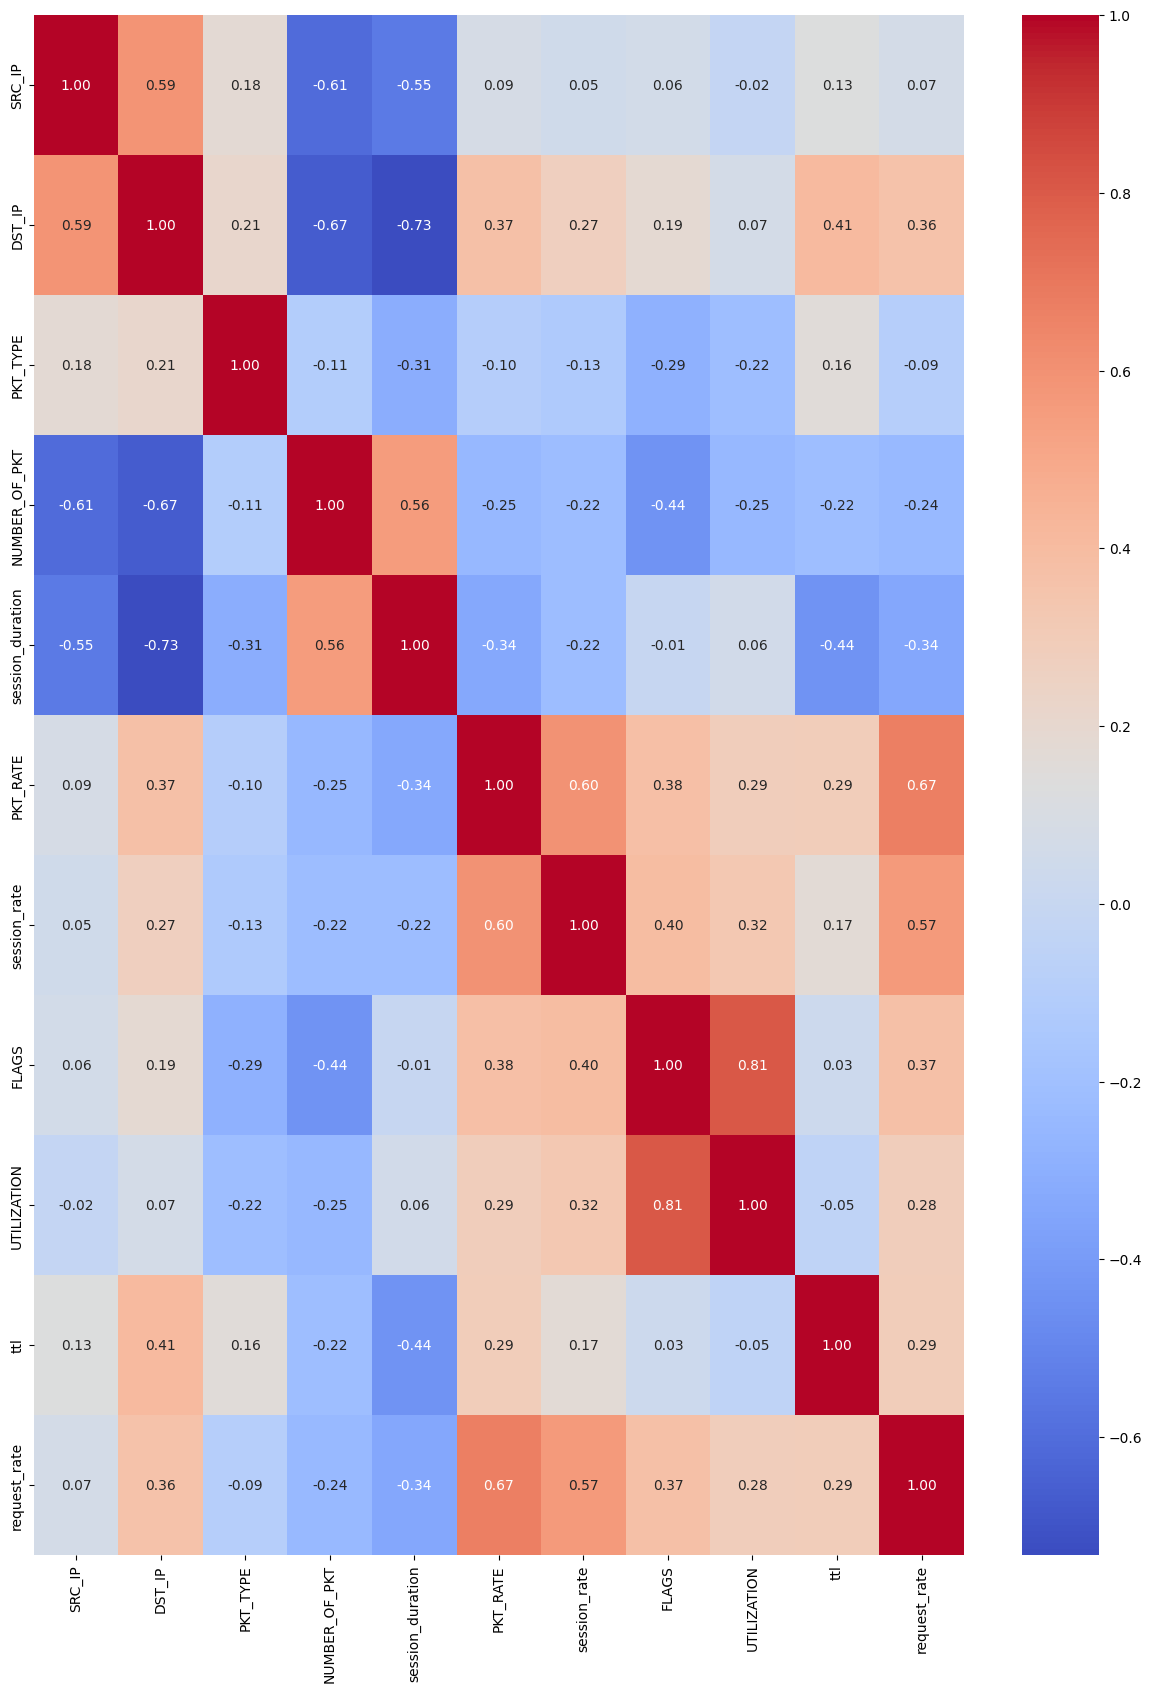

In [17]:
corr_matrix = X_train.corr()
plt.figure(figsize=(15, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.show()

# Results
From this corr matrix we can see red points strong correlation between features. We can see request rate and ttl have a strong relationship, and many more.


# Feature Selection

In [18]:
# columns_to_drop = ["NUMBER_OF_BYTE", "BYTE_RATE", "SRC_ADD", "DES_ADD", "PKT_ID", "FROM_NODE", "TO_NODE", "PKT_SIZE", "FID", "SEQ_NUMBER", "NODE_NAME_FROM", "NODE_NAME_TO", "PKT_IN", "PKT_OUT", "PKT_DELAY_NODE", "PKT_AVG_SIZE", "PKT_SEND_TIME", "PKT_RESEVED_TIME", "FIRST_PKT_SENT", "LAST_PKT_RESEVED", "request_time", "PKT_R", "PKT_DELAY" ]
columns_to_drop = ["SRC_IP", "DST_IP"]
X_train =  X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)
X_val = X_val.drop(columns=columns_to_drop)

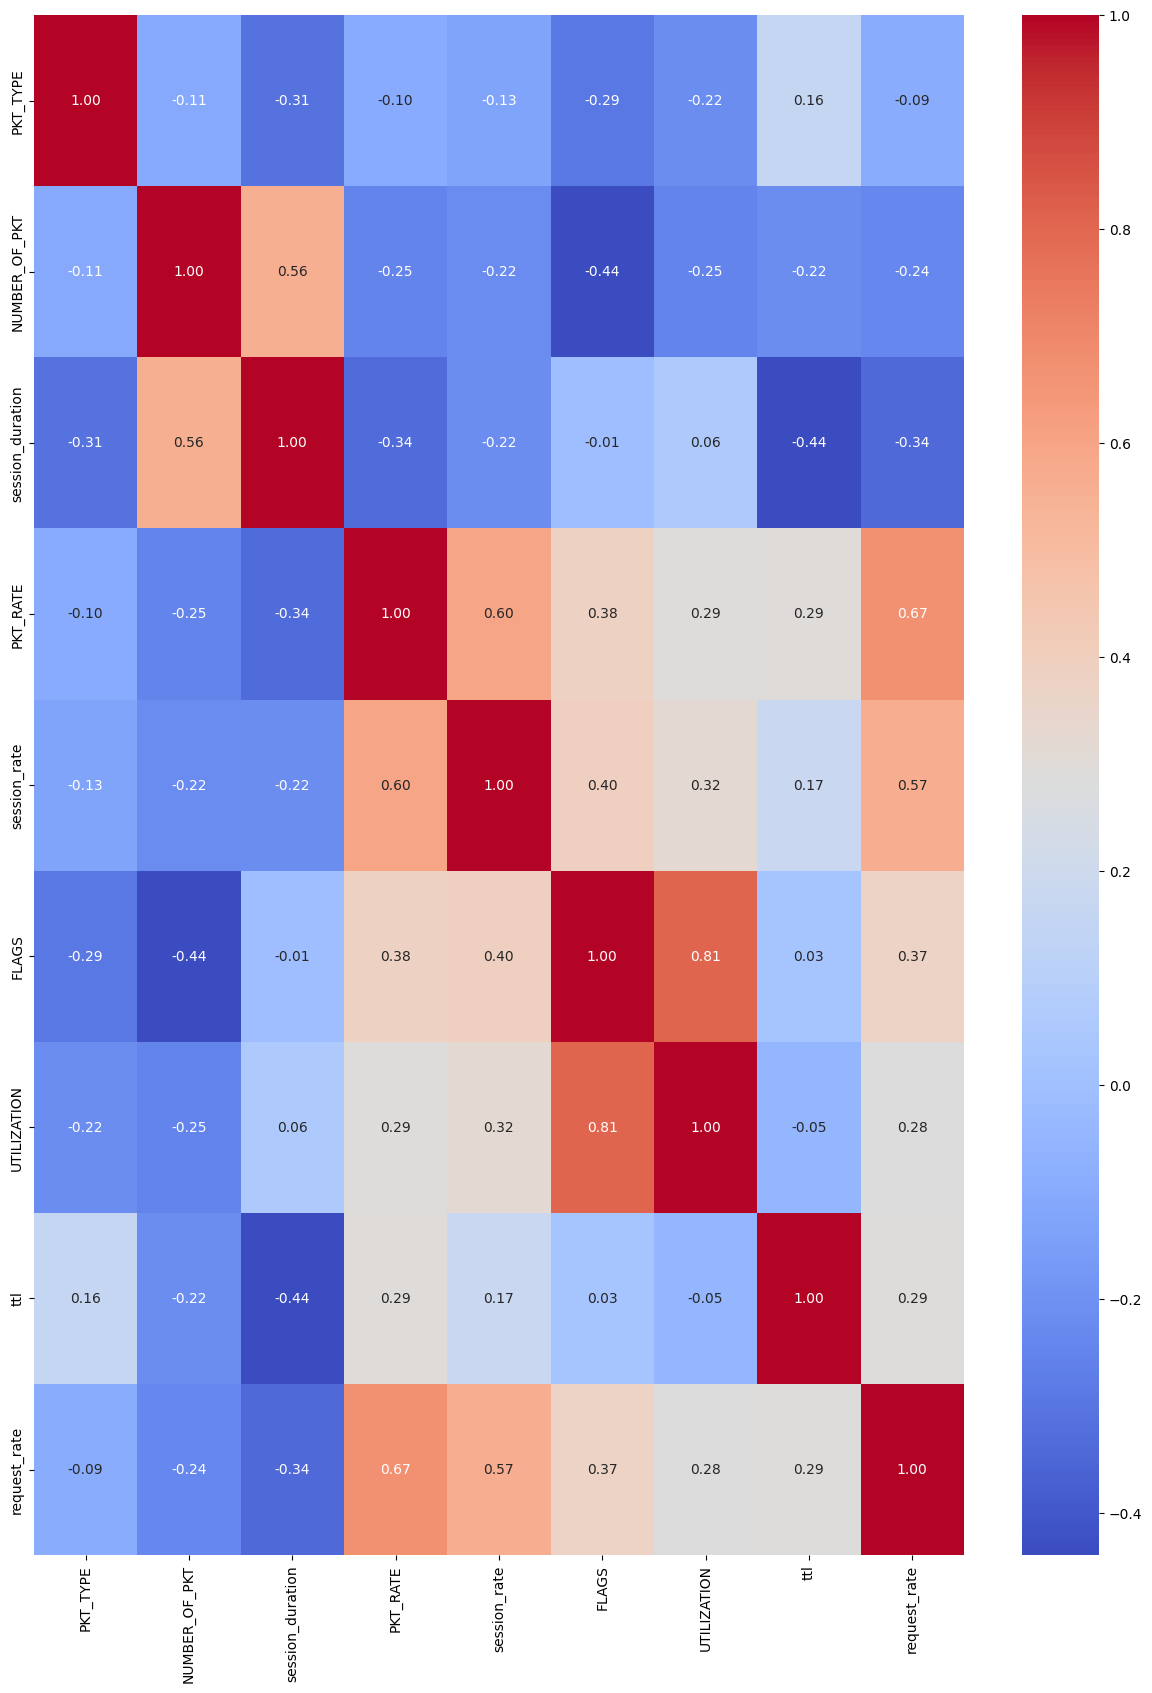

In [19]:
corr_matrix = X_train.corr()
plt.figure(figsize=(15, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.show()

# Model
Training Model

In [20]:
X_test.head()

,PKT_TYPE,NUMBER_OF_PKT,session_duration,PKT_RATE,session_rate,FLAGS,UTILIZATION,ttl,request_rate
3570,0,13260.000000,9.711864,1833.281999,407649.804996,16.0,39.563973,64,1763.377731
8194,1,533.960415,6.897818,3683.965661,170946.297500,2.0,9.924272,255,9135.513428
635,0,901.000000,3.666094,245.765657,313237.194682,16.0,5.200000,64,245.765657
3533,0,19896.000000,9.843500,1296.566138,371717.507399,18.0,66.144833,64,1585.298749
7452,1,15172.433230,7.899218,14184.346910,449491.840300,2.0,5.546709,255,16220.942560


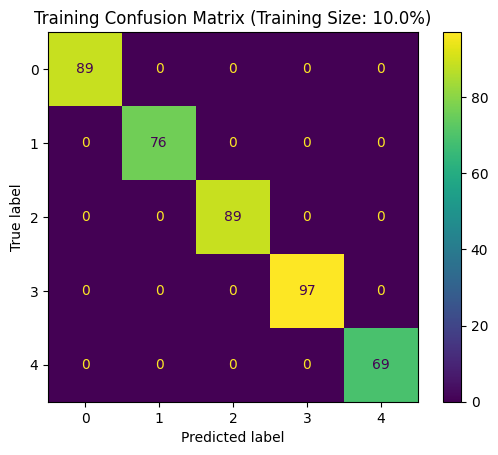

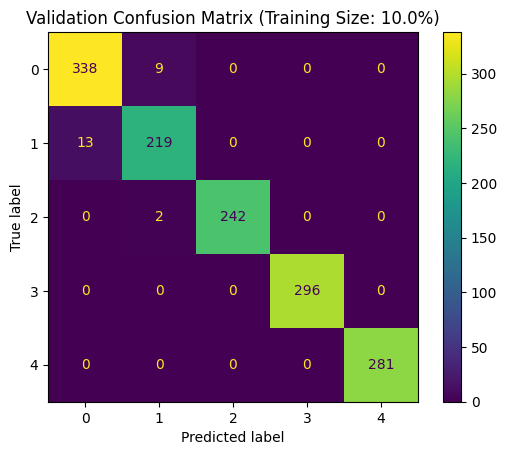

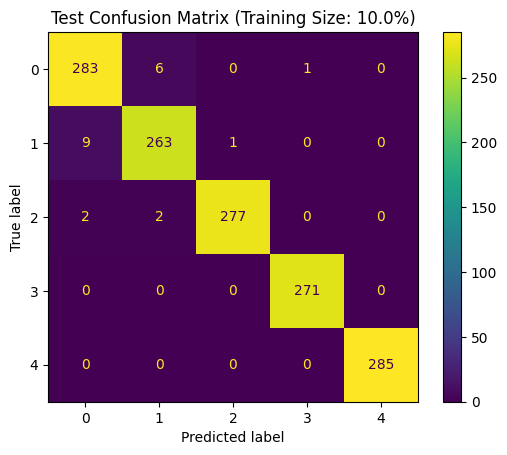

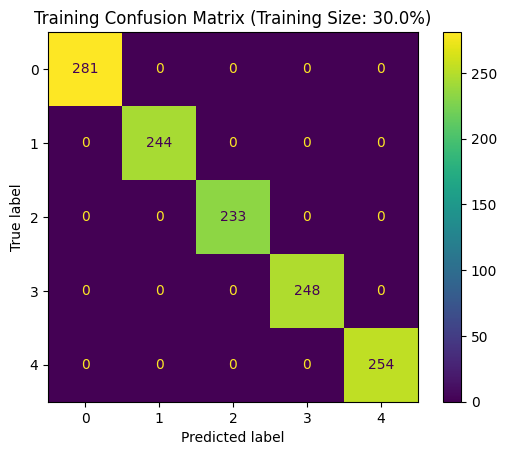

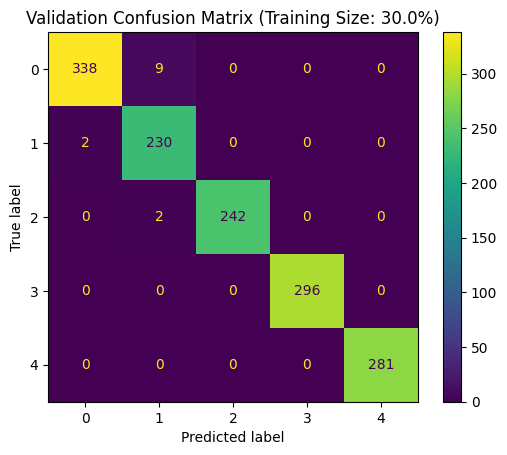

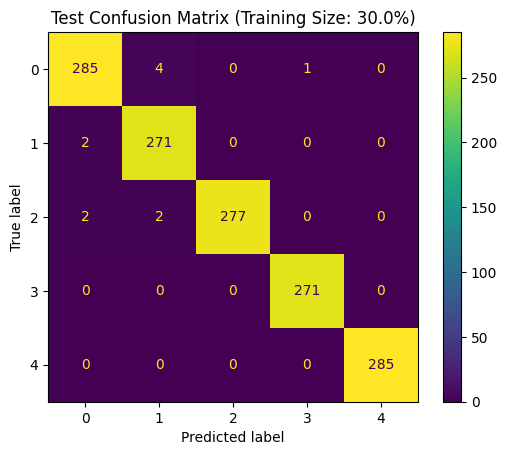

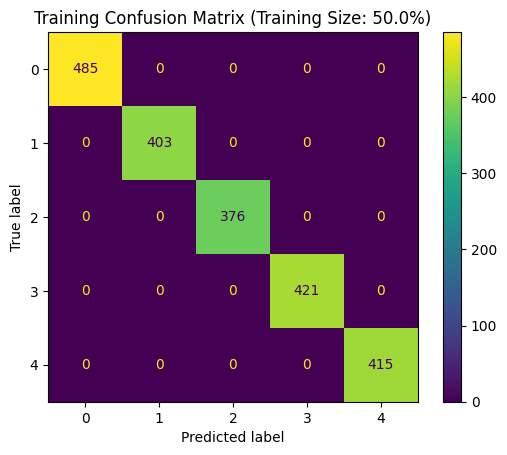

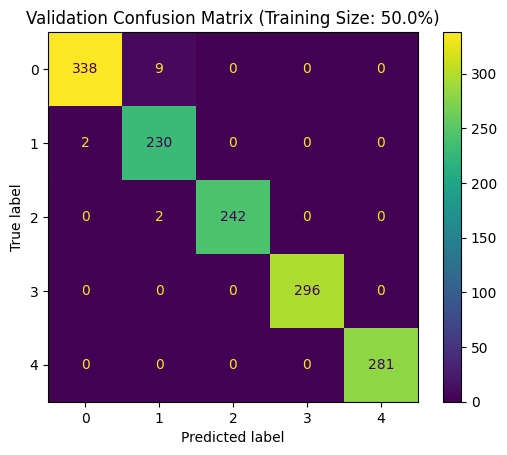

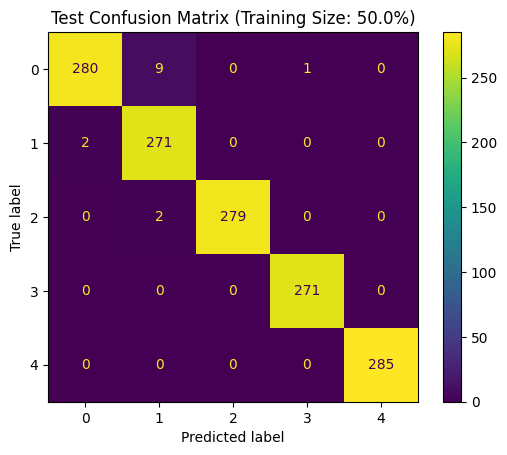

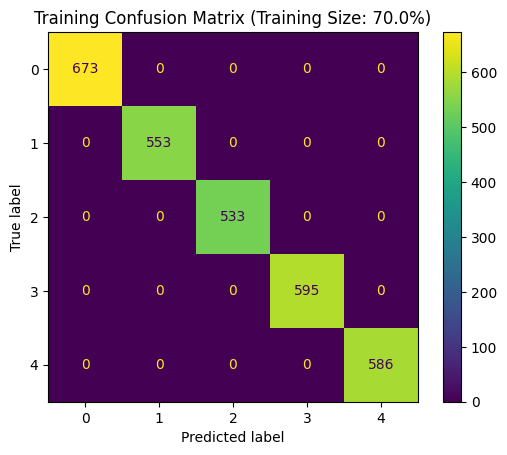

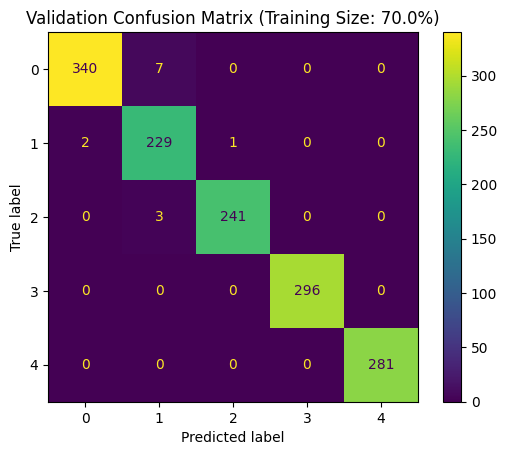

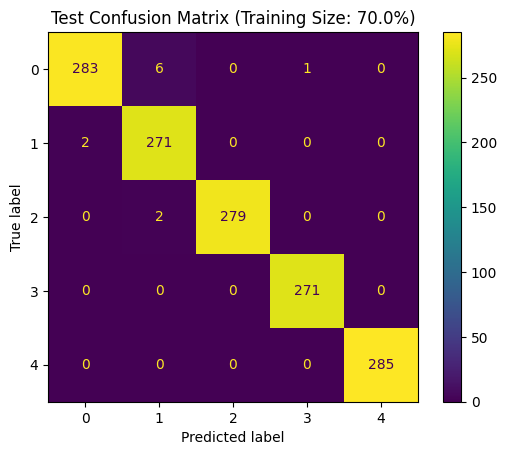

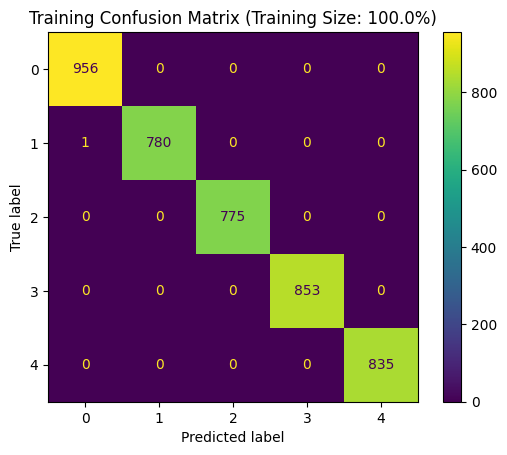

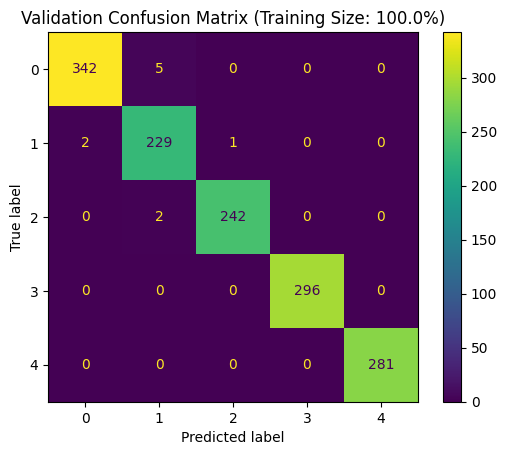

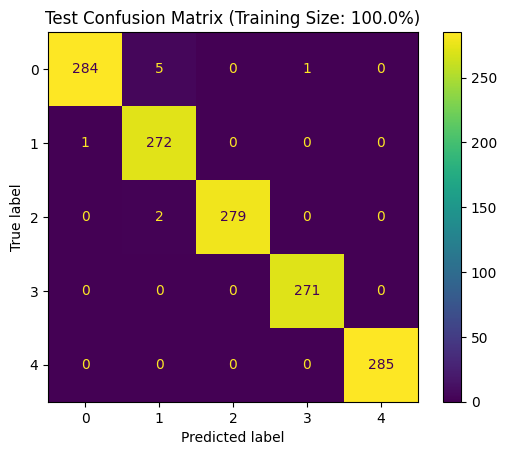

['random_forest_model.joblib']

In [21]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
train_scores = []
validation_scores = []
test_scores = []
X_test_with_predictions = pd.DataFrame()

model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
y_test_report = None
for size in train_sizes:
    # Subsampling data, to get interval values for plotting values
    X_train_sample = X_train[:int(size * len(X_train))]
    y_train_sample = Y_train[:int(size * len(Y_train))]

    # Training the model
    model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    model.fit(X_train_sample, y_train_sample)

    Y_train_acc = model.predict(X_train_sample)
    Y_val_acc = model.predict(X_val)
    Y_test_acc = model.predict(X_test)

    train_acc = accuracy_score(y_train_sample, Y_train_acc)
    train_scores.append(train_acc)
    val_acc = accuracy_score(Y_val, Y_val_acc)
    validation_scores.append(val_acc)
    test_acc = accuracy_score(Y_test, Y_test_acc)
    test_scores.append(test_acc)

    train_cm = confusion_matrix(y_train_sample, Y_train_acc)
    val_cm = confusion_matrix(Y_val, Y_val_acc)
    test_cm = confusion_matrix(Y_test, Y_test_acc)

    disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
    disp.plot()
    plt.title(f'Training Confusion Matrix (Training Size: {size * 100}%)')
    plt.show()


    disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
    disp.plot()
    plt.title(f'Validation Confusion Matrix (Training Size: {size * 100}%)')
    plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
    disp.plot()
    plt.title(f'Test Confusion Matrix (Training Size: {size * 100}%)')
    plt.show()




    X_test_temp = X_test.copy()
    X_test_temp['predicted'] = Y_test_acc


    X_test_with_predictions = pd.concat([X_test_with_predictions, X_test_temp], ignore_index=True)


dump(model, 'random_forest_model.joblib')


    # Display or store combined data (X_test with predictions)
    # print(X_test_with_predictions.head())  # Display first 5 rows


In [22]:
print(X_test_with_predictions.head())

   PKT_TYPE  NUMBER_OF_PKT  session_duration      PKT_RATE   session_rate  \
0         0   13260.000000          9.711864   1833.281999  407649.804996   
1         1     533.960415          6.897818   3683.965661  170946.297500   
2         0     901.000000          3.666094    245.765657  313237.194682   
3         0   19896.000000          9.843500   1296.566138  371717.507399   
4         1   15172.433230          7.899218  14184.346910  449491.840300   

   FLAGS  UTILIZATION  ttl  request_rate  predicted  
0   16.0    39.563973   64   1763.377731  TCP Flood  
1    2.0     9.924272  255   9135.513428  GET Flood  
2   16.0     5.200000   64    245.765657     Normal  
3   18.0    66.144833   64   1585.298749  TCP Flood  
4    2.0     5.546709  255  16220.942560  GET Flood  


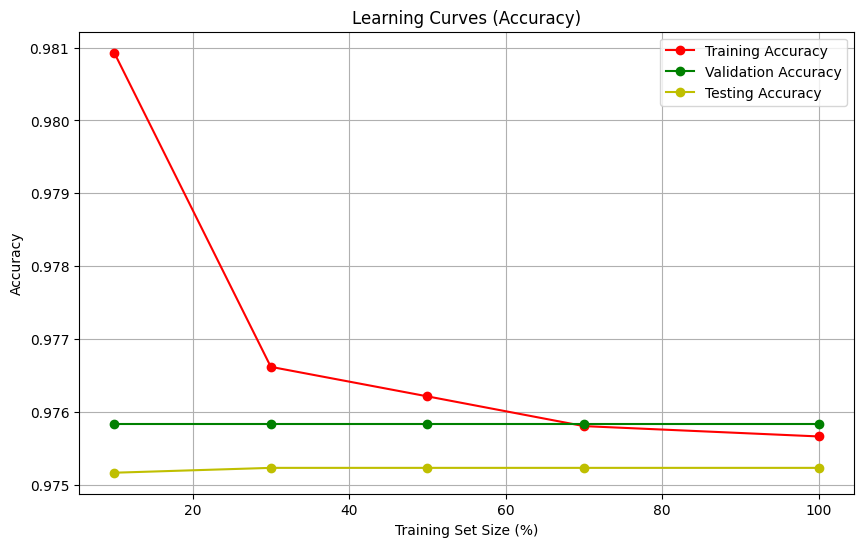

In [ ]:

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(np.array(train_sizes) * 100, train_scores, 'o-', color="r", label="Training Accuracy")
plt.plot(np.array(train_sizes) * 100, validation_scores, 'o-', color="g", label="Validation Accuracy")
plt.plot(np.array(train_sizes) * 100, test_scores, 'o-', color="y", label="Testing Accuracy")
plt.title('Learning Curves (Accuracy)')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid()
plt.show()

# # Loss Curves
# plt.figure(figsize=(10, 6))
# plt.plot(np.array(train_sizes) * 100, train_losses, 'o-', color="r", label="Training Loss")
# plt.plot(np.array(train_sizes) * 100, validation_losses, 'o-', color="g", label="Validation Loss")
# plt.plot(np.array(train_sizes) * 100, test_losses, 'o-', color="y", label="Testing Loss")
# plt.title('Learning Curves (Loss)')
# plt.xlabel('Training Set Size (%)')
# plt.ylabel('MSE')
# plt.legend(loc="best")
# plt.grid()
# plt.show()